# Imports

In [1276]:
import sys, os

from math import log10
from numpy import array, pi

import pandas as pd
import numpy as np
from numpy import concatenate
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from hist import Hist
import hist
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc, accuracy_score, classification_report
from sklearn.base import clone
# algorithms:
from sklearn.tree import export_graphviz, DecisionTreeClassifier#, plot_tree, export_text # Available in later versions
#import graphviz

# Setup plotting

In [1277]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

# Parameters

In [1278]:
ana_thresh_e = 3.5
single_e_size = 47.07

# Get data

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
12117,6998,9713,15797.84082,61.862862,335.624407,39.079861,30.85253,49.790703,4880.0,0,cathode,10.0,60.0,150.0,140.0,260.0,240.0


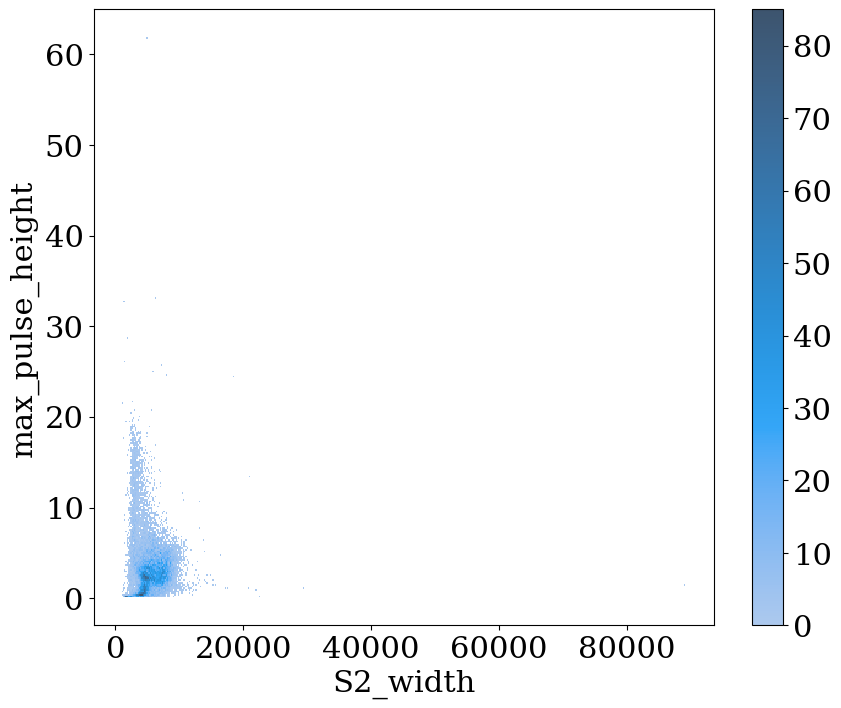

In [1279]:
df1 = pd.read_csv('data/tritium_ML_data.csv')
df2 = pd.read_csv('data/bg_sr1_vetoes.csv')

df = pd.concat([df1,df2], ignore_index=True)
df = df.drop('Unnamed: 0', axis = 1)
df.head()
#df.type[0]

pairplot_features = ['dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90', 'ext_elec', 'S2_width', 'max_pulse_height', 'r']

plt.figure()
#sns.pairplot(df, x_vars=pairplot_features, y_vars=pairplot_features, kind='hist')
sns.histplot(df, x='S2_width', y='max_pulse_height', cbar=True)#, binrange=((0, 31000), (0, 35)))

df[df.max_pulse_height == np.max(df.max_pulse_height)]
# df[['runID', 'eventID']][df.max_pulse_height > 25]
# print(df['runID'][df.max_pulse_height > 25], df['eventID'][df.max_pulse_height > 25])

In [1280]:
df[df.S2_width == np.max(df.S2_width)]

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
14478,6942,132368,20157.527344,1.394301,428.245748,8.389941,-32.467159,33.533678,89130.0,1,gate,3680.0,10280.0,22080.0,18010.0,12020.0,5420.0


# Re-weight data

In [1281]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

In [1282]:
# df['ext_elec'] = df.area/electron_size

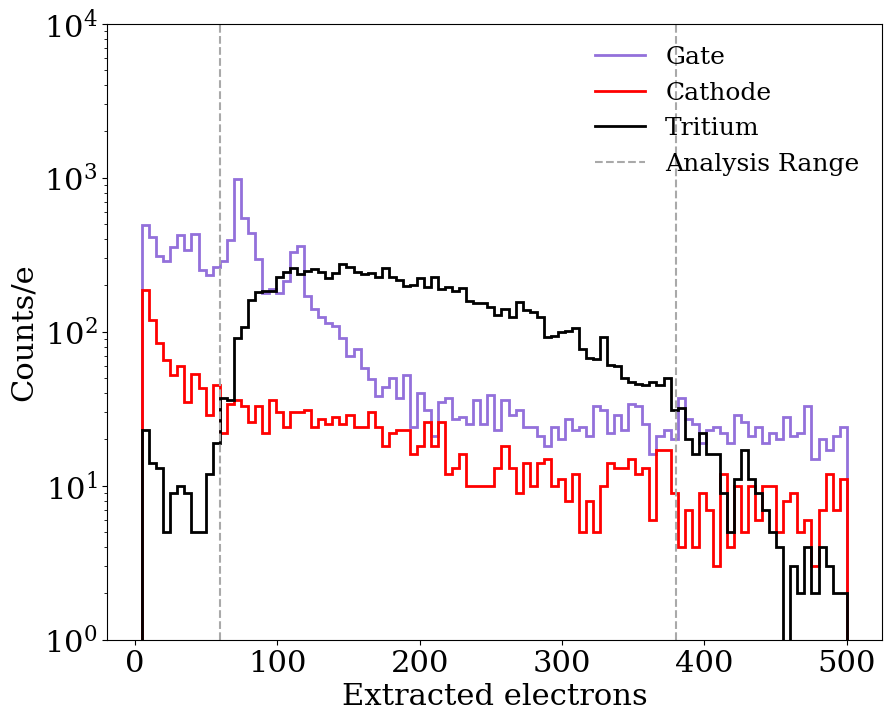

In [1283]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cathode"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [1284]:
# implementing thresholds
thresh_cut = (60 < df.ext_elec) & (df.ext_elec < 380)
df_cut = df[thresh_cut].reset_index().drop('index', axis = 1)

In [1285]:
# handscanning the weird cathode data bumps 
S2_gate_cut = (70 < df.ext_elec) & (df.ext_elec < 120)
for ii in range(1,11):
    print('%s\t%s'%(df.runID[S2_gate_cut].to_numpy()[ii], df.eventID[S2_gate_cut].to_numpy()[ii]))

8144	59142
8144	59902
8154	86148
8153	136792
8139	32009
8151	66996
8151	67428
8161	96447
8141	65314
8151	114316


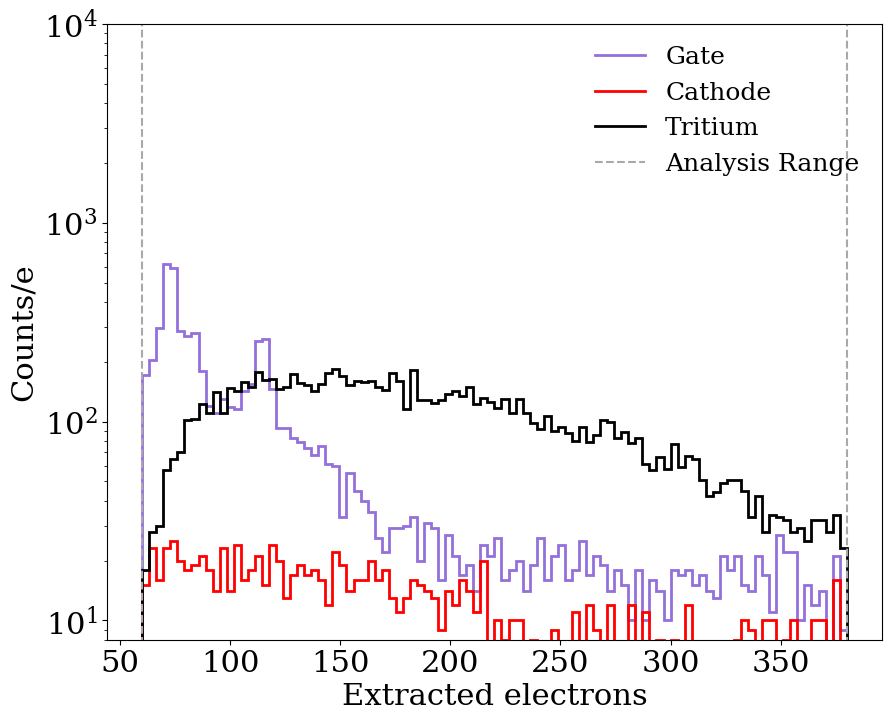

In [1286]:
# histogram with threshold data

electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_cut.type == "gate"
gate_hist2.fill(df_cut.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_cut.type == "cathode"
cath_hist2.fill(df_cut.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_cut.type == "tritium"
trit_hist2.fill(df_cut.ext_elec[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [1287]:
weight_list = []

for ii in range(df_cut.shape[0]):
    if df_cut.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_cut.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_cut.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_cut.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_cut.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_cut.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_cut['weights'] = weight_list

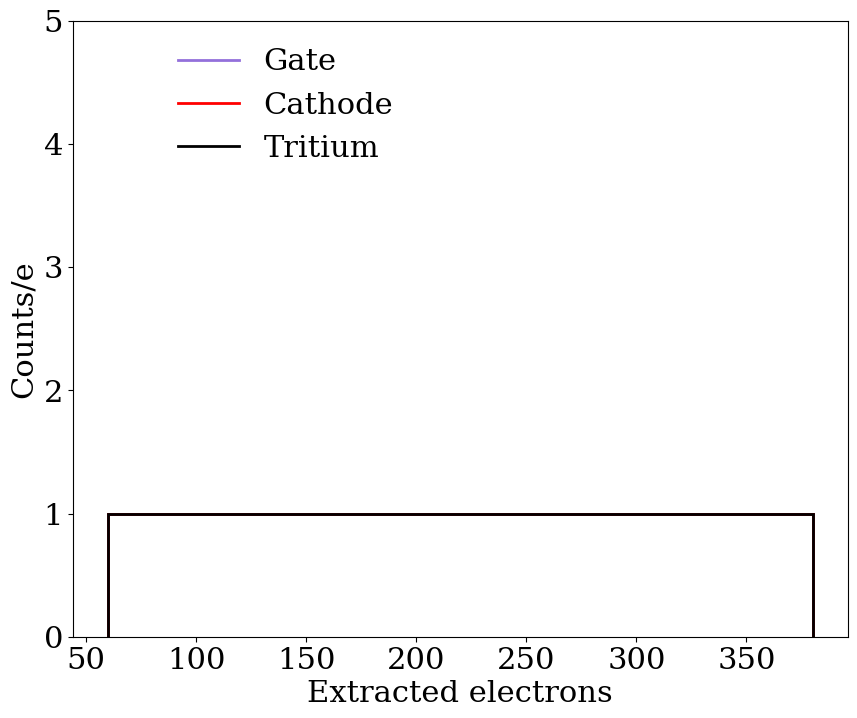

In [1288]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_cut.ext_elec[gate_cut2],weight = df_cut.weights[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_cut.ext_elec[cath_cut2],weight = df_cut.weights[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_cut.ext_elec[trit_cut2],weight = df_cut.weights[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

# Machine learning

### Prepare data for machine learning

- Note that the signal types are labelled in the 'label' field as follows:
    - Cathode - 0
    - Gate - 1
    - Tritium - 2

In [1289]:
df_ML = df[df.ext_elec > ana_thresh_e]#.loc[:,features]
#df_ML = df_cut
df_ML.head()
# plt.figure()
# sns.pairplot(df_ML)

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


In [1290]:
features = ['dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90', 'ext_elec', 'max_pulse_height', 'S2_width']

X = df_cut[features]
Y = df_cut['label']
T = df_cut['type']
W = df_cut['weights'] # - should this be the weight calculated above? 
A = df_cut['area']
R = df_cut['r']
X_raw = df_cut['x']
Y_raw = df_cut['y']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
T_train, T_test, \
W_train, W_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test = \
train_test_split(X, Y, A, T, W, R, X_raw, Y_raw, random_state=0)
# print(Y)
# print(Y[11000])
# print(T)
# print(T[11000])

# features = ['max_pulse_height', 'dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90', 'ext_elec']

# X = df_ML[features]
# Y = df_ML['label']
# T = df_ML['type']
# W = df_ML['weight']
# A = df_ML['area']
# R = df_ML['r_raw']
# X_raw = df_ML['x_raw']
# Y_raw = df_ML['y_raw']
# L = df_ML['luxstamp']
# X_train_unscaled, X_test_unscaled, \
# Y_train, Y_test, \
# W_train, W_test, \
# A_train, A_test, \
# T_train, T_test, \
# R_train, R_test, \
# X_raw_train, X_raw_test, \
# Y_raw_train, Y_raw_test, \
# L_train, L_test = \
# train_test_split(X, Y, W, A, T, R, X_raw, Y_raw, L, random_state=0)

In [1291]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
X_test = scaler.transform(X_test_unscaled.astype('float64'))
E_test = A_test/single_e_size

### Adaptively boosted decision tree

In [1292]:
DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC = AdaBoostClassifier(estimator=DTC,n_estimators=100,algorithm = 'SAMME')
model = ABC.fit(X_train, Y_train.values.ravel()
                ,sample_weight=W_train.values.ravel().astype('float64'))

Y_score = model.decision_function(X_test)

model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
model.score(X_test, Y_test, sample_weight=W_test.astype('float64'))

(0.8090454095426818, 0.7994340276818332)

In [1293]:
print('Feature Importances\n')
for i in range(len(features)):
    print(str(features[i]) + ' - ' + str(model.feature_importances_[i]))

Feature Importances

dt10_05 - 0.05862165847066283
dt25_10 - 0.15218623327369568
dt50_25 - 0.19632497359689116
dt75_50 - 0.10341072747192094
dt90_75 - 0.053246802402439425
dt95_90 - 0.035613553688833746
ext_elec - 0.14141905018749582
max_pulse_height - 0.1666017912096277
S2_width - 0.09257520969843294


# Understanding machine learning

In [1294]:
bin_labels = ['Total', r'60 < $n_e$ < 100', r'100 < $n_e$ < 140', r'140 < $n_e$ < 180', r'180 < $n_e$ < 220',
              r'220 < $n_e$ < 240', r'240 < $n_e$ < 280', r'280 < $n_e$ < 320', r'320 < $n_e$ < 380']
bin_colors = ["black", "purple", "darkblue", "cyan", "green", "gold", "orange", "red", "hotpink"  ]

In [1295]:
test_error_list = []
start = 60
for i in range(8):
    test_error = [ ]
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    for test_predict in model.staged_predict(X_test[bin_cut]):
        test_error.append(1.-accuracy_score(test_predict,Y_test[bin_cut],sample_weight=W_test[bin_cut].ravel().astype('float64')))
    test_error_list.append(test_error)

Text(0, 0.5, 'Test Error')

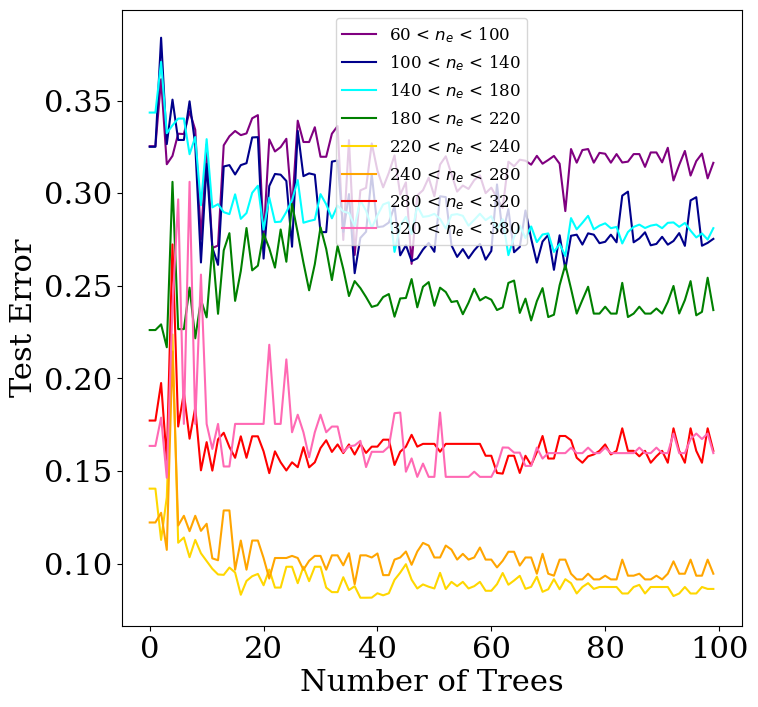

In [1296]:
fig, ax = plt.subplots(figsize=(8,8))
for i in range(8):
    ax.plot(test_error_list[i], color = bin_colors[i+1], label=bin_labels[i+1])
ax.legend(fontsize = 12)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Test Error')

# Results

In [1297]:
# FPR_T, TPR_T, TH_T = roc_curve(Y_test,Y_score,sample_weight = W_test,pos_label = 2)

In [1298]:
# TH_T

In [1299]:
# TPR_T

In [1300]:
Y_score

array([[0.15323344, 0.40594608, 0.44082049],
       [0.1706962 , 0.42188704, 0.40741676],
       [0.33220085, 0.21501667, 0.45278248],
       ...,
       [0.14383044, 0.4097326 , 0.44643696],
       [0.12255707, 0.41372436, 0.46371857],
       [0.43921993, 0.21127786, 0.34950221]])

## Bins for ROC curves

- Full range (60-380)
- For now will do evenly spaced bins i.e:

60-100 100-140 140-180 180-220 220-260 260-300 300-340 340-380

In [1301]:
# Finding max efficiency ratio 
def eff_calc(e_s, e_b):
        return np.divide(e_s, np.sqrt(e_b), out=np.zeros_like(e_s), where=e_b!=0)

def max_efficiencies(ROC_params_list):
        maxes = []
        ratios_list = []
        for i in range(len(ROC_params_list)):
                e_s = ROC_params_list[i][1]
                e_b = ROC_params_list[i][0]
                ratios = np.divide(e_s, np.sqrt(e_b), out=np.zeros_like(e_s), where=e_b!=0)
                ratios_list.append(ratios)
                ind = np.where(ratios == np.max(ratios))
                maxes.append([e_s[ind], e_b[ind]])
        return maxes

def min_distance_efficiency(ROC_params_list):
        effs = []
        for i in range(len(ROC_params_list)):
                e_s = ROC_params_list[i][1]
                e_b = ROC_params_list[i][0]
                dists = np.sqrt((e_b - 0)**2 + (e_s - 1)**2)
                optimal_idx = np.argmin(dists)
                effs.append([e_s[optimal_idx], e_b[optimal_idx]])
        return effs


# def eff_calc(e_s, e_b):
#         return np.divide(e_s, np.sqrt(e_b), out=np.zeros_like(e_s), where=e_b!=0)
# maxes = []
# ratios_list = []
# for i in range(9):
#         ratios = eff_calc(ROC_params_list[i][1], ROC_params_list[i][0])
#     ratios_list.append(ratios)
#     ind = np.where(ratios == np.max(ratios))
#     maxes.append([ROC_params_list[i][1][ind], ROC_params_list[i][0][ind]])

# Determining the multiclass roc curve
# Need to make the three class system into a binary system for ROC
# def multiclass_roc_curve(y_true, y_score, signal_class_index=2, weights=None, bkg_type='cathode'):
#     if bkg_type == 'cathode':
#         cut_ = (T_test != 'gate')
#     elif bkg_type == 'gate':
#         cut_ = (T_test != 'cathode')
#     else:
#         raise ValueError('bkg_type either "gate" or "cathode"')
#     y_score_signal = y_score[:, signal_class_index]
#     y_test_signal_vs_bgk = np.where(y_true == signal_class_index, 1, 0)
#     print(weights.shape)
#     print(y_score_signal.shape)
#     print(y_test_signal_vs_bgk.shape)

#     # Compute ROC curve
#     if weights is not None:
#         fpr, tpr, th = roc_curve(y_test_signal_vs_bgk[cut_], y_score_signal[cut_], sample_weight=weights)
#         roc_curve_auc = roc_auc_score(y_test_signal_vs_bgk[cut_], y_score_signal[cut_], sample_weight=weights)
#     else:
#         fpr, tpr, th = roc_curve(y_test_signal_vs_bgk[cut_], y_score_signal[cut_])
#         roc_curve_auc = auc(fpr, tpr)
#     return [fpr, tpr, th, roc_curve_auc]


In [1302]:
# splitting into gate and cathode
ROC_params_gate = []
ROC_params_cath = []
start = 60
gate_plus_trit = (T_test != 'cathode')
cath_plus_trit = (T_test != 'gate')
y_score_signal = Y_score[:, 2]
for i in range(8): 
    bin_cut = (start < E_test) & (E_test < start + 40)
    # get Y_test, excluding cathode events and assign 1 to signal and 0 to gate
    y_test_signal_vs_gate = np.where(Y_test[gate_plus_trit&bin_cut] == 2, 1, 0)
    # get Y_test, excluding gate events and assign 1 to signal and 0 to cathode
    y_test_signal_vs_cath = np.where(Y_test[cath_plus_trit&bin_cut] == 2, 1, 0)
    # get decision function for the signal class only
    start += 40
    FPR, TPR, TH = roc_curve(y_test_signal_vs_gate,y_score_signal[gate_plus_trit&bin_cut],sample_weight = W_test[gate_plus_trit&bin_cut])
    ROC_params_gate.append([FPR, TPR, TH])
    FPR, TPR, TH = roc_curve(y_test_signal_vs_cath,y_score_signal[cath_plus_trit&bin_cut],sample_weight = W_test[cath_plus_trit&bin_cut])
    ROC_params_cath.append([FPR, TPR, TH])

# print(Y_test.shape)
    # print(Y_test[gate_plus_trit&bin_cut].shape)
    # print(Y_test[cath_plus_trit].shape)
    # print()
    # print(y_score_signal.shape)
    # print(y_score_signal[gate_plus_trit&bin_cut].shape)
    # print()
    # y_test_gate_trit_bin = Y_test[gate_plus_trit&bin_cut]
    # y_test_cath_trit_bin = Y_test[cath_plus_trit&bin_cut]
# print(y_test_signal_vs_gate.shape)
    # print(y_score_signal[gate_plus_trit&bin_cut].shape)
    # print(W_test[gate_plus_trit&bin_cut].shape)
    # roc_y_score = Y_score[bin_cut]
    # roc_weights = W_test

In [1303]:
# maxes = []
# ratios_list = []
# for i in range(9):
#     ratios = eff_calc(ROC_params_list[i][1], ROC_params_list[i][0])
#     ratios_list.append(ratios)
#     ind = np.where(ratios == np.max(ratios))
#     maxes.append([ROC_params_list[i][1][ind], ROC_params_list[i][0][ind]])

Text(0.5, 1.0, 'Gate ROC Curve')

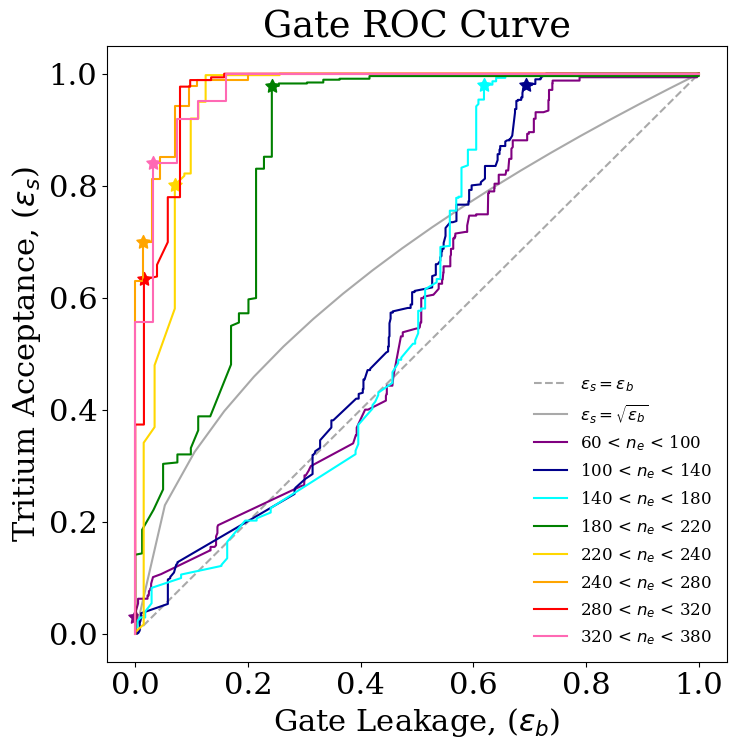

In [1304]:
gate_sig_max_effs = max_efficiencies(ROC_params_gate)
gate_sig_min_dists = min_distance_efficiency(ROC_params_gate)

e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_gate[i][0], ROC_params_gate[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    ax.scatter(gate_sig_max_effs[i][1], gate_sig_max_effs[i][0], color = bin_colors[i+1], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)
plt.title('Gate ROC Curve')

Text(0.5, 1.0, 'Cathode ROC Curve')

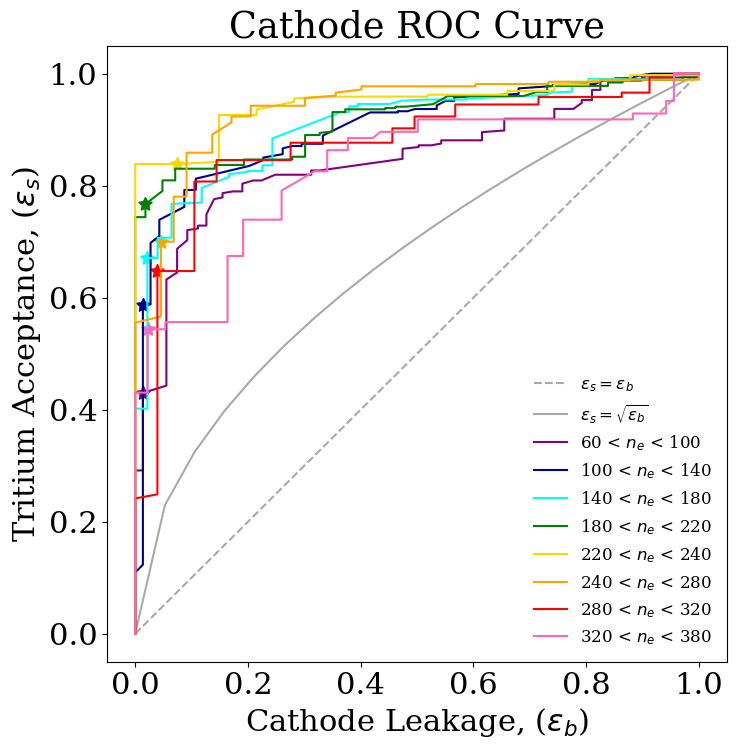

In [1305]:
cath_sig_max_effs = max_efficiencies(ROC_params_cath)
gate_sig_min_dists = min_distance_efficiency(ROC_params_cath)

e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_cath[i][0], ROC_params_cath[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    ax.scatter(cath_sig_max_effs[i][1], cath_sig_max_effs[i][0], color = bin_colors[i+1], s = 100, marker = (5,1))
ax.set_xlabel(r'Cathode Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)
plt.title('Cathode ROC Curve')

# Discriminator Score Plots

[ 94.30256591 110.12963157 290.79097621 ... 208.95634577 252.83103539
 210.15784752]
2625      94.302566
2111     110.129632
6298     290.790976
2760     228.920835
17296     75.681784
            ...    
13714    115.512468
6577     156.211411
3536     208.956346
6502     252.831035
6249     210.157848
Name: ext_elec, Length: 4452, dtype: float64
(4452, 3)


Text(0, 0.5, 'Gate Probability')

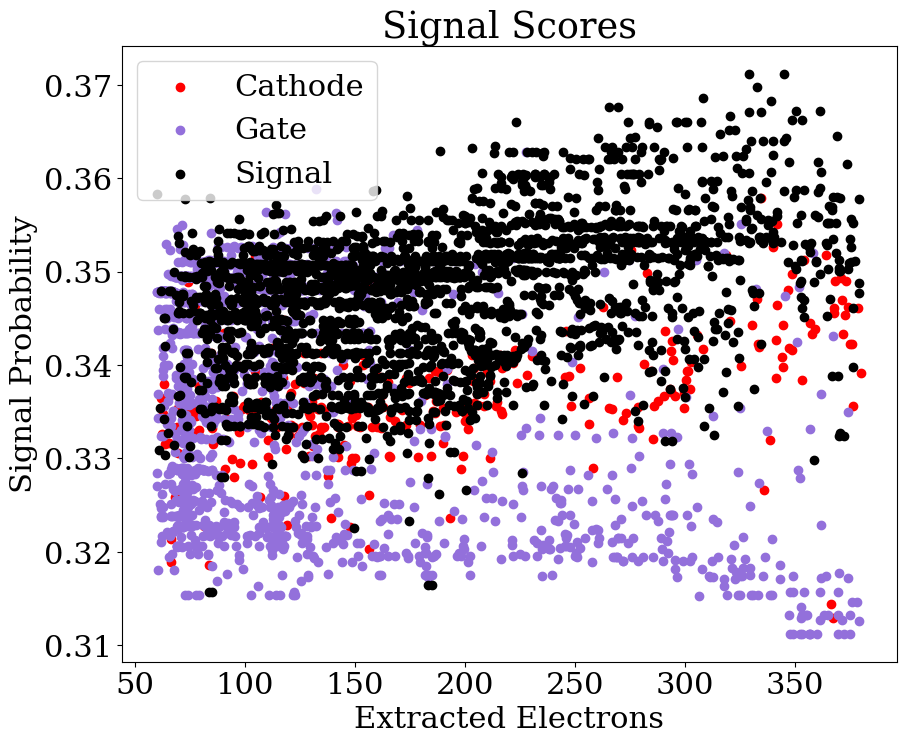

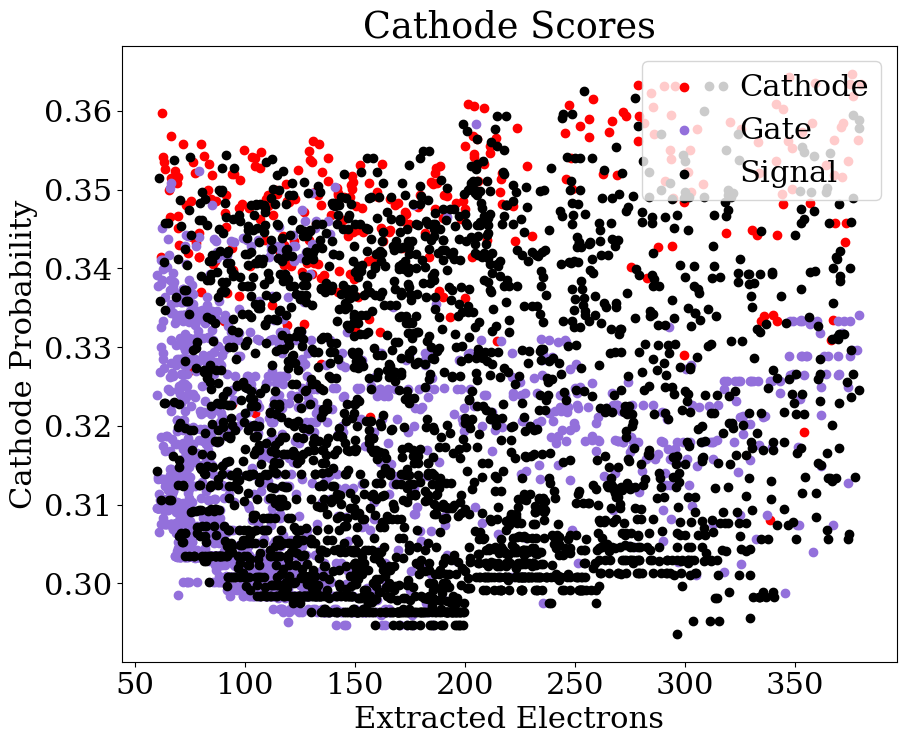

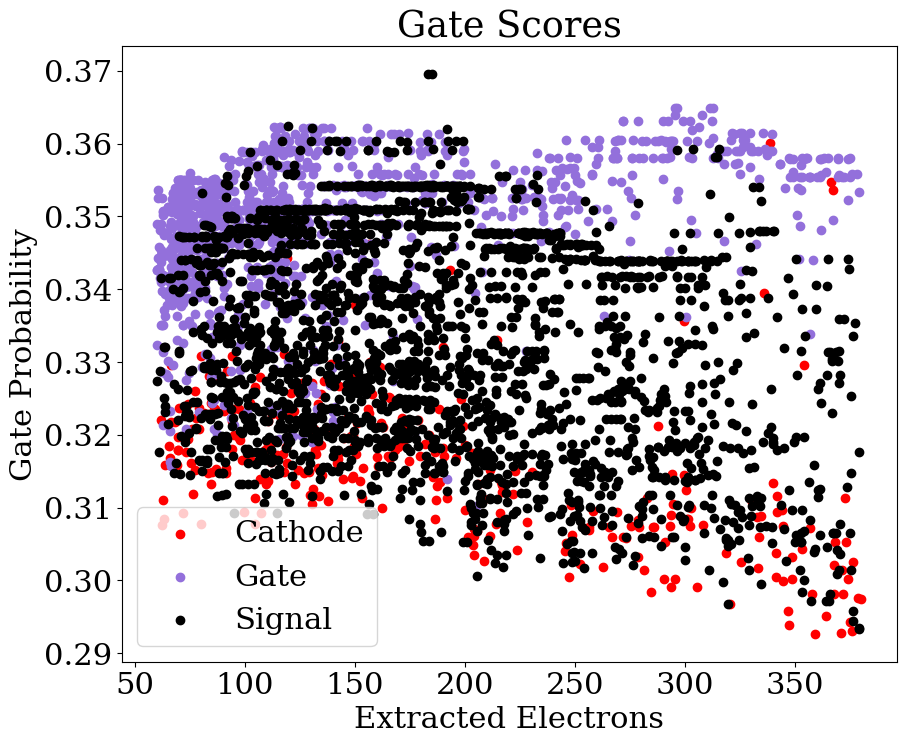

In [1306]:
print(E_test.to_numpy())
print(X_test_unscaled['ext_elec'])
print(Y_score.shape)

extracted_electrons = E_test.to_numpy()

probs = model.predict_proba(X_test)
probs_cath = probs[:,0]
probs_gate = probs[:,1]
probs_signal = probs[:,2]

# for X_test, index [:, 6] returns the extracted electron data

# signal discrimination plot
fig, ax = plt.subplots(figsize=(10, 8))
# cathode
# plt.scatter(extracted_electrons, Y_score[:, 0],color='red',ls='-',lw=2,label='Cathode')
# plt.scatter(extracted_electrons[T_test=='cathode'], y_score_signal[T_test=='cathode'],color='red',ls='-',lw=2,label='Cathode')
plt.scatter(extracted_electrons[T_test=='cathode'], probs_signal[T_test=='cathode'],color='red',label='Cathode')
# gate discriminator plot
# plt.scatter(extracted_electrons, Y_score[:, 1],color='mediumpurple',ls='-',lw=2,label='Gate')
# plt.scatter(extracted_electrons[T_test=='gate'], y_score_signal[T_test=='gate'],color='mediumpurple',ls='-',lw=2,label='Gate')
plt.scatter(extracted_electrons[T_test=='gate'], probs_signal[T_test=='gate'],color='mediumpurple',label='Gate')
# tritiu, discriminator plot
# plt.scatter(extracted_electrons, Y_score[:, 2],color='black',ls='-',lw=2,label='Tritium')
# plt.scatter(extracted_electrons[T_test=='tritium'], y_score_signal[T_test=='tritium'],color='black',ls='-',lw=2,label='Signal')
plt.scatter(extracted_electrons[T_test=='tritium'], probs_signal[T_test=='tritium'],color='black',label='Signal')
plt.title('Signal Scores')
plt.legend()
plt.xlabel('Extracted Electrons')
# plt.ylabel('Signal Discriminator Score')
plt.ylabel('Signal Probability')

y_score_cath = Y_score[:,0]
# cathode discrimination plot
fig, ax = plt.subplots(figsize=(10, 8))
# cathode
# plt.scatter(extracted_electrons, Y_score[:, 0],color='red',ls='-',lw=2,label='Cathode')
# plt.scatter(extracted_electrons[T_test=='cathode'], y_score_cath[T_test=='cathode'],color='red',ls='-',lw=2,label='Cathode')
plt.scatter(extracted_electrons[T_test=='cathode'], probs_cath[T_test=='cathode'],color='red',label='Cathode')
# gate discriminator plot
# plt.scatter(extracted_electrons, Y_score[:, 1],color='mediumpurple',ls='-',lw=2,label='Gate')
# plt.scatter(extracted_electrons[T_test=='gate'], y_score_cath[T_test=='gate'],color='mediumpurple',ls='-',lw=2,label='Gate')
plt.scatter(extracted_electrons[T_test=='gate'], probs_cath[T_test=='gate'],color='mediumpurple',label='Gate')
# tritiu, discriminator plot
# plt.scatter(extracted_electrons, Y_score[:, 2],color='black',ls='-',lw=2,label='Tritium')
# plt.scatter(extracted_electrons[T_test=='tritium'], y_score_cath[T_test=='tritium'],color='black',ls='-',lw=2,label='Signal')
plt.scatter(extracted_electrons[T_test=='tritium'], probs_cath[T_test=='tritium'],color='black',label='Signal')
plt.title('Cathode Scores')
plt.legend()
plt.xlabel('Extracted Electrons')
# plt.ylabel('Cathode Discriminator Score')
plt.ylabel('Cathode Probability')

y_score_gate = Y_score[:,1]
# gate discrimination plot
fig, ax = plt.subplots(figsize=(10, 8))
# cathode
# plt.scatter(extracted_electrons, Y_score[:, 0],color='red',ls='-',lw=2,label='Cathode')
# plt.scatter(extracted_electrons[T_test=='cathode'], y_score_gate[T_test=='cathode'],color='red',ls='-',lw=2,label='Cathode')
plt.scatter(extracted_electrons[T_test=='cathode'], probs_gate[T_test=='cathode'],color='red',label='Cathode')
# gate discriminator plot
# plt.scatter(extracted_electrons, Y_score[:, 1],color='mediumpurple',ls='-',lw=2,label='Gate')
# plt.scatter(extracted_electrons[T_test=='gate'], y_score_gate[T_test=='gate'],color='mediumpurple',ls='-',lw=2,label='Gate')
plt.scatter(extracted_electrons[T_test=='gate'], probs_gate[T_test=='gate'],color='mediumpurple',label='Gate')
# tritiu, discriminator plot
# plt.scatter(extracted_electrons, Y_score[:, 2],color='black',ls='-',lw=2,label='Tritium')
# plt.scatter(extracted_electrons[T_test=='tritium'], y_score_gate[T_test=='tritium'],color='black',ls='-',lw=2,label='Signal')
plt.scatter(extracted_electrons[T_test=='tritium'], probs_gate[T_test=='tritium'],color='black',label='Signal')
plt.title('Gate Scores')
plt.legend()
plt.xlabel('Extracted Electrons')
# plt.ylabel('Gate Discriminator Score')
plt.ylabel('Gate Probability')

# gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
# cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
# trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
